In [1]:
import pandas as pd 
import process as process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.dropna() # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

In [28]:
import EMA_CV

import warnings 
from PyFolioC import PyFolioC
warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

##################################################################### PARAMETERS #####################################################################
number_of_repetitions = 10
lookback_window = [3065,3265]  ## new lookback_window
evaluation_window = 5
number_of_clusters = 38
cov_method = 'signed_laplacian'
sigma = 0.01
eta = 0.02
number_of_window = 302
data = df_cleaned

beta = 0.99
K = 4  # Number of fold for the cross validation
######################################################################################################################################################

##################################################################### PORTFOLIO ######################################################################
ewafolio = EMA_CV.EWA_sliding_window(number_of_window, eta, beta, data, lookback_window, evaluation_window, short_selling=True, markowitz_type='min_volatility')

step 1/302, portfolio value: 1.0104
step 2/302, portfolio value: 1.0189
step 3/302, portfolio value: 1.0349
step 4/302, portfolio value: 1.0355
step 5/302, portfolio value: 1.0465
step 6/302, portfolio value: 1.0522
step 7/302, portfolio value: 1.0389
step 8/302, portfolio value: 1.0337
step 9/302, portfolio value: 1.0490
step 10/302, portfolio value: 1.0555
step 11/302, portfolio value: 1.0574
step 12/302, portfolio value: 1.0635
step 13/302, portfolio value: 1.0518
step 14/302, portfolio value: 1.0708
step 15/302, portfolio value: 1.0426
step 16/302, portfolio value: 1.0523
step 17/302, portfolio value: 1.0607
step 18/302, portfolio value: 1.0769
step 19/302, portfolio value: 1.0978
step 20/302, portfolio value: 1.0987
step 21/302, portfolio value: 1.0827
step 22/302, portfolio value: 1.0776
step 23/302, portfolio value: 1.0736
step 24/302, portfolio value: 1.0419
step 25/302, portfolio value: 1.0597
step 26/302, portfolio value: 1.0667
step 27/302, portfolio value: 1.0705
step 28/30

In [26]:
import process

## NAIVE: SP500
start_date = '2013-01-01'
end_date = '2019-12-31'
sp500_PnL = process.get_sp500_PnL(start_date, end_date)

# Generate the 1510 dates between the start and end dates
dates = pd.date_range(start=start_date, end=end_date, periods=1510)

def cumulative_returns(portfolio):

    # Compute cumulative returns
    cumulative_returns_res = (1 + portfolio).cumprod()

    return cumulative_returns_res

interpolated_sp500_PnL = np.interp(np.linspace(0, len(sp500_PnL) - 1, 1510), np.arange(len(sp500_PnL)), sp500_PnL)

portfolio_value_sp500 = cumulative_returns(interpolated_sp500_PnL)

cum_returns = cumulative_returns(ewafolio[0])

## PORTFOLIO VALUES ##
initial_investment = 1
portfolio_value_res = initial_investment * cum_returns 
portfolio_value_sp500 = cumulative_returns(interpolated_sp500_PnL)


[*********************100%%**********************]  1 of 1 completed


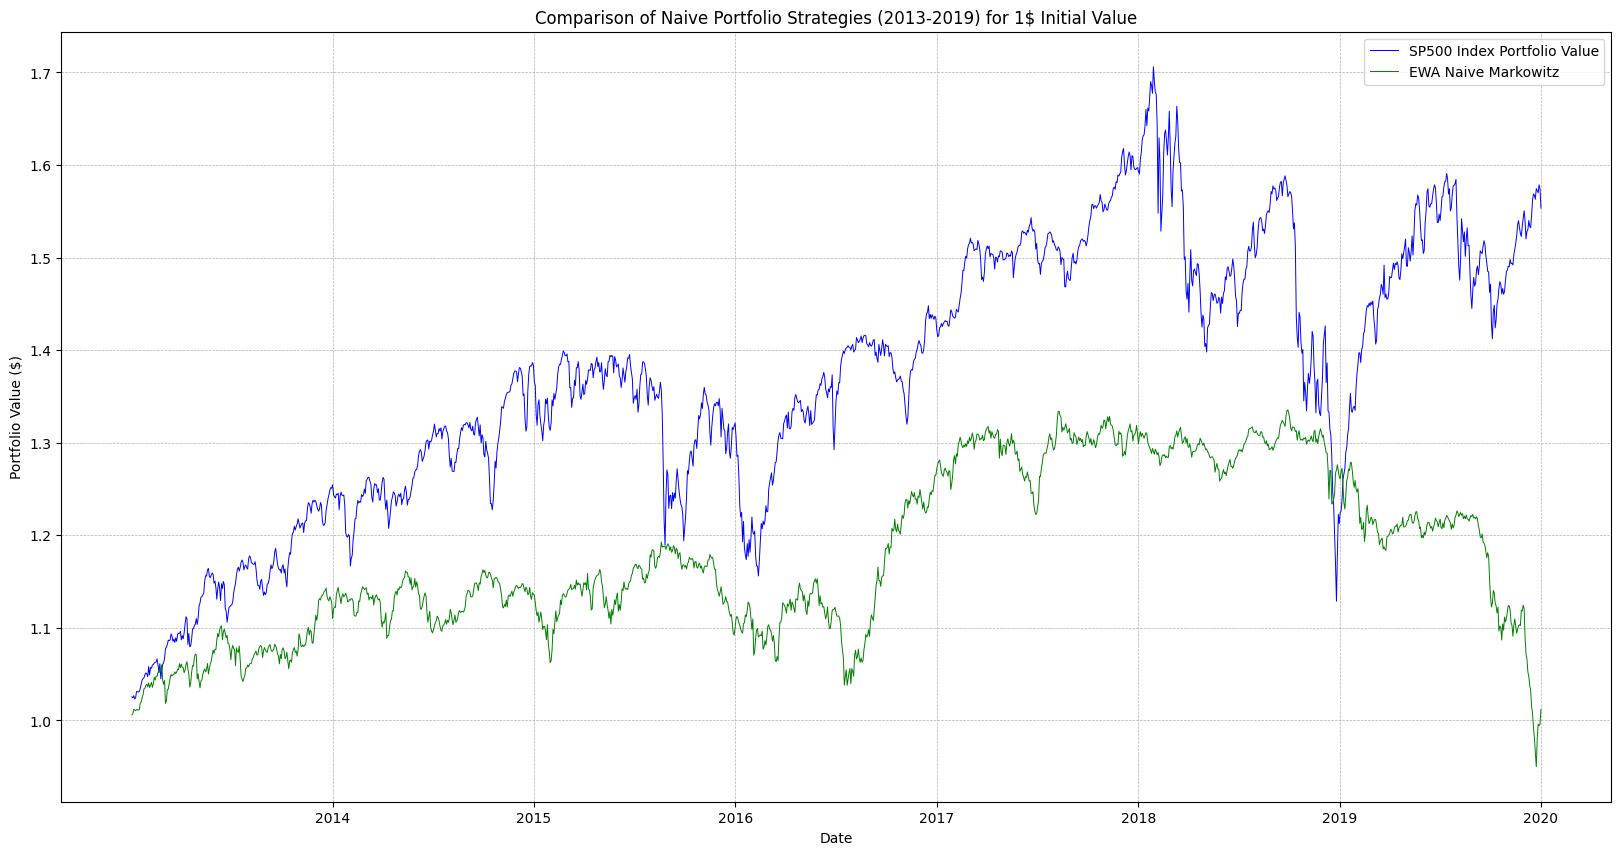

In [27]:
import matplotlib.pyplot as plt

# Generate date range
start_date = '2013-01-01'
end_date = '2019-12-31'
dates = pd.date_range(start=start_date, end=end_date, periods=1510)

# Plot the evolution of the portfolio value
plt.figure(figsize=(20, 10))
plt.plot(dates, portfolio_value_sp500, color='blue', linestyle='-', linewidth=0.7, label='SP500 Index Portfolio Value')  # Adjust appearance here
plt.plot(dates, portfolio_value_res, color='green', linestyle='-', linewidth=0.7, label='EWA Naive Markowitz') 

plt.title('Comparison of Naive Portfolio Strategies (2013-2019) for 1$ Initial Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Customize x-axis ticks and labels
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='Y'), range(2014, 2021))

plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enable grid with dashed lines
plt.show()

In [23]:
year = '2013-2019'
clustering_method = 'EWA_only'

portfolio_mark = pd.DataFrame(portfolio_value_res.values, columns=['PnL'])

portfolio_mark.to_csv(f'PnL_{year}_{clustering_method}_shortselling_eval_window={evaluation_window}__shortselling_eval_window={evaluation_window}_beta={beta}_eta={eta}_sigma={sigma}.csv', index=False)

In [3]:
######################### 1. We start by randomizing the auxiliary observation matrix  ̃X from Equation (5) along the time axis #########################
def auxilary_matrix(lookback_window, beta, df_cleaned):

    ## 1. We extract the data corresponding to the returns of our assets (columns) during these d days (lines)
    X = df_cleaned.iloc[lookback_window[0]:lookback_window[1],:] ## shape days * number of stocks
    n_days = len(lookback_window)
    ## 2. We slightly adjust the matrix of observations to get the auxiliary matrix that puts more weight on recent dates

    # Compute the weight matrix : shape (days, days) (if days = 250, shape (250, 250))
    W = np.sqrt(np.diag(n_days * (1 - beta) * beta**(np.arange(lookback_window[0], lookback_window[1])[::-1]) / (1 - beta**n_days)))  
    X_tilde = pd.DataFrame(index=X.index, columns=X.columns, data=np.dot(W, X))

    ## 3. We randomize the auxiliary matrix of observations according to the time axis
    # Randomized_X = X_tilde.transpose().sample(frac=1, axis=1, random_state=42) ## we transpose X as we want to have daily observations of the whole dataset !

    return X_tilde ## shape (days, 695)

# ---------------------------------------------------------------- TESTS ----------------------------------------------------------------

lookback_window = [0, 250]
beta = 0.999
X_tilde = auxilary_matrix(lookback_window=lookback_window, beta=beta, df_cleaned=df_cleaned)

We split the (randomized) auxiliary observations into $K$ non-overlapping folds **of equal size** represented as $\{\mathcal{I}_k | \mathcal{I}_k \subset \{1, ..., K\}\}_{k=1}^K$. Each set indexed by $\mathcal{I}_k$ works as a **"test" fold**, while the remaining observations' indices constitute a **"training" fold**,

In [4]:
from sklearn.model_selection import ShuffleSplit

######################### 2. We then split the (randomized) auxiliary observations into K non-overlapping folds of equal size #########################
def shuffle_split(data, K):
    # Initialize ShuffleSplit
    shuffle_split = ShuffleSplit(n_splits=K, test_size=0.2, random_state=42) 
    # test_size=0.2 : 20% des données pour l'ensemble de test, 80% pour l'ensemble d'entraînement.

    # Create empty list to store splits
    splits = []

    # Perform shuffling and splitting
    for train_index, test_index in shuffle_split.split(data.index):
        train_fold = [data.index[i] for i in train_index]
        test_fold = [data.index[i] for i in test_index]
        splits.append((train_fold, test_fold)) ## attention à cette structure

    return splits

In [5]:
######################### 3. For each K fold configuration, we estimate the sample eigenvectors from the training set #########################

def eigen_sample(data, beta, train_fold):
    ## 1. We extract the data corresponding to the returns of our assets (columns) during these d days (lines)
    X = data.loc[train_fold] ## shape days * number of stocks
    days = len(train_fold) 

    # Compute the weight matrix : shape (days, days) (if days = 250, shape (250, 250))
    W = np.sqrt(np.diag(days * (1 - beta) * beta**(np.arange(days)[::-1]) / (1 - beta**days)))  

    # We compute the auxiliary matrix
    X_tilde = np.dot(W, X)

    # We compute the training sample exponential moving average 
    sample_expo_cov = np.dot(X_tilde.T, X_tilde)

    # Calculer les vecteurs et valeurs propres de la matrice de covariance
    _, eigenvectors_train = np.linalg.eigh(sample_expo_cov) ## .eigh and not .eig so that the eigenvalues are real 

    return eigenvectors_train

# ---------------------------------------------------------------- TESTS ----------------------------------------------------------------
lookback_window = [0, 250]
beta = 0.999
X_tilde = auxilary_matrix(lookback_window=lookback_window, beta=beta, df_cleaned=df_cleaned)
splits = shuffle_split(data=X_tilde, K=5)
eigenvectors_train = eigen_sample(data=df_cleaned, beta=0.99, train_fold=splits[0][0]) ## input : df_cleaned
eigenvectors_train

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.05, -0.02],
       [-0.57,  0.31, -0.  , ..., -0.01, -0.  , -0.02],
       [-0.36, -0.23, -0.07, ...,  0.01,  0.05, -0.01],
       ...,
       [ 0.01, -0.  ,  0.03, ...,  0.02, -0.01, -0.04],
       [ 0.03,  0.03, -0.  , ..., -0.02,  0.04, -0.04],
       [-0.  , -0.01,  0.02, ...,  0.01, -0.  , -0.  ]])

We consider a fixed exponential decay rate $\beta \in (0, 1)$ an its associated EWA-SC $\bm{E}$. Remember we denoted $\bm{\Sigma}$ the "true" and unobserved covariance matrix. Both these matrices are symmetric and thus admit the following spectral decomposition: 

\begin{equation}
\bm{E} = \sum_{i=1}^{n} \hat{\lambda}_i \hat{u}_i \hat{u}_i', \quad \text{and} \quad \bm{\Sigma} = \sum_{i=1}^{n} \lambda_i u_i u_i',
\end{equation}

where $(\hat{\lambda}_1, \ldots, \hat{\lambda}_n; \hat{u}_1, \ldots, \hat{u}_n)$  denotes a system of sample eigenvalues and eigenvectors of $\bm{E}$, and $(\lambda_1, \ldots, \lambda_n; u_1, \ldots, u_n)$ denotes a system of eigenvalues and eigenvectors of the "true" covariance $\bm{\Sigma}$. The eigenvalues are assumed to be sorted in ascending order.

To correct the bias previously mentioned, we consider a specific framework where the sample eigenvalues should be corrected while retaining the sample eigenvectors of the original matrix. This is mathematically tantamount to write:

\begin{equation}
\hat{\bm{\Sigma}} = \sum_{i=1}^{n} \xi_i \hat{u}_i \hat{u}_i',
\end{equation}

where $\bm{\xi} = (\xi_i)_{i=1,...,n}$  is an $n$-dimensional vector that we have to obtain. This framework is somewhat reasonable as, in absence of any **a priori** knowledge about the structure of the covariance matrix, the most natural guess that we have about the population eigenvectors is the sample eigenvectors that we observe. 

- For each $K$ fold configuration, we estimate the sample eigenvectors from the training set and then estimate an N-dimensional vector of out-of-sample variances using the test set and the sample eigenvectors. 

- Finally, we average the out-of-sample variance estimates over $K$ to give us the bias-corrected eigenvalue of the ith sample eigenvector portfolio denoted as $\xi^{\dagger}_i$ for all $i$.

These two last steps are equivalent to introducing the $K$-fold cross-validation estimator:

$$
\xi^{\dagger}_i := \frac{1}{K} \sum_{k=1}^K \sum_{t \in \mathcal{I}_k}  \frac{1}{\lvert \mathcal{I}_k \rvert} \left(\hat{u}_i[k]'\tilde{x}_t \right)^2, \quad \text{for } i = 1, \ldots, n,
$$

where: 
- $\lvert \mathcal{I}_k \rvert$ denotes the cardinality of the kth test set such that each of them is approximately equal in size, that is, $K \lvert \mathcal{I}_k \rvert \approx d$
- Here, $\hat{u}_i[k]$ is the $i$-th sample eigenvector of a sample covariance matrix that is obtained from the training fold, and $\tilde{x}$ is a sample vector of the auxiliary observation matrix from the test fold.

In [6]:
def intra_fold_loss(data, test_fold, sample_eigenvector_i, beta): ## we test the data on this test fold

    ## 1. get the fold cardinality 
    fold_cardinality = len(test_fold) ## 20% of the observations

    ## 2. sample vector of the auxiliary observation matrix from the test fold (inspired from the code above)

    days = len(test_fold)
    X = data.loc[test_fold] ## shape (days, 695)

    ## 2. We slightly adjust the matrix of observations to get the auxiliary matrix that puts more weight on recent dates

    W = np.sqrt(np.diag(days * (1 - beta) * beta**(np.arange(days)[::-1]) / (1 - beta**days)))  # shape (days, days)
    X_tilde = pd.DataFrame(index=X.index, columns=X.columns, data=np.dot(W, X)) # shape (days, 695)

    res = (np.dot(sample_eigenvector_i, X_tilde.T) ** 2)  # shape (, 695) * (695, days) = (, days)
    result = np.sum(res) / fold_cardinality ## sum over days / size of the test sample

    return result

# ---------------------------------------------------------------- TESTS ----------------------------------------------------------------
beta = 0.99
data = X_tilde
sample_eigenvector_i = eigenvectors_train[:, 0]
test_fold = splits[0][1]
intra_loss = intra_fold_loss(data=data, test_fold=test_fold, sample_eigenvector_i=sample_eigenvector_i, beta=beta)
intra_loss

0.00043027390620140266

In [7]:
def average_loss(data, splits, index, beta):

    res = 0 ## to stock the overall loss

    for (train_fold, test_fold) in splits:

        ## sur chaque fold, on calcule les sample eigenvectors à partir du training fold correspondant

        sample_eigenvector_i = eigen_sample(data=data, beta=beta, train_fold=train_fold)[:, index] ## on ne garde que l'eigenvector correspondant au bon index

        ## sur chaque fold, on calcule la perte au sein du fold à partir de l'échantillon de test

        res = res + intra_fold_loss(data=data, test_fold=test_fold, sample_eigenvector_i=sample_eigenvector_i, beta=beta)

    res = res / len(splits) ## we average by the number of folds (which corresponds to the lengths of the splits)

    return res

# ---------------------------------------------------------------- TEST ----------------------------------------------------------------
average_loss_0 = average_loss(data=df_cleaned, splits=splits, index=0, beta=0.99)

In [72]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [13]:
np.set_printoptions(precision=10)

from tqdm import tqdm

def eigenvalue_estimator(data, splits, beta):

    number_of_stocks = len(data.columns) ## COLUMNS HAVE TO BE COMPOSED OF THE STOCKS TICKERS

    xi = np.zeros(number_of_stocks)  # initialisation de x

    for i in tqdm(range(number_of_stocks), desc='Calcul en cours', unit='itération'):
        xi[i] = average_loss(data=data, splits=splits, index=i, beta=beta)   
                       
    return xi

# ---------------------------------------------------------------- TEST ----------------------------------------------------------------

In [14]:
def EMA_CV(data, beta, lookback_window, number_of_folds):

    days = len(lookback_window)
    ## compute the sample exponential moving average correlation matrix
    X = data.iloc[lookback_window[0]:lookback_window[1],:]
    W = np.sqrt(np.diag(days * (1 - beta) * beta**(np.arange(lookback_window[0], lookback_window[1])[::-1]) / (1 - beta**days)))  
    X_tilde = np.dot(W, X)  # Produit matriciel de X' et W
    S = np.dot(X_tilde.T, X_tilde)

    ## compute the eigenvectors of S
    _, eigenvectors = np.linalg.eigh(S)

    ## computes the estimator 
    X_tilde = auxilary_matrix(lookback_window=lookback_window, beta=beta, df_cleaned=data)
    splits = shuffle_split(data=X_tilde, K=number_of_folds)
    eigenvalue_est = eigenvalue_estimator(data=data, splits=splits, beta=beta)

    # Initialisation de Sigma avec des zéros
    Sigma = np.zeros((S.shape[0], S.shape[1]), dtype=np.complex128)

    # Parcourir chaque vecteur propre et valeur propre
    for i in range(len(data.columns)):
        xi_dagger = eigenvalue_est[i]  # Conjugue de xi
        ui = eigenvectors[:, i]  # i-ème vecteur propre

        # Calcul du produit externe xi^† * ui * ui^† et addition à Sigma
        Sigma += xi_dagger * np.outer(ui, ui) 

    # Sigma est maintenant la somme des produits xi^† * ui * ui^†
    Sigma = pd.DataFrame(index=data.columns, columns=data.columns, data=np.real(Sigma))

    return Sigma

EMA_CV(data=df_cleaned, beta=0.99, lookback_window=[0, 250], number_of_folds=5)

Calcul en cours:   4%|▍         | 29/695 [00:21<08:22,  1.33itération/s]


KeyboardInterrupt: 